# Relativistic approximations of the Saha and Planck function in white dwarfs
 relatavstic statmechimcs in white dwarfs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy.constants as c
import astropy.units as u


In [10]:
# T and n in log space 
T = np.logspace(10, 20, 100)
n = np.logspace(20, 30, 100)

A = c.h**3 *c.c**5 / (8*np.pi* c.k_B**3)
A = A.value
B = c.m_p**2 * c.c**4 
B = B.value



In [15]:
mu = np.log(A * n/T )*c.k_B.value*T  + B

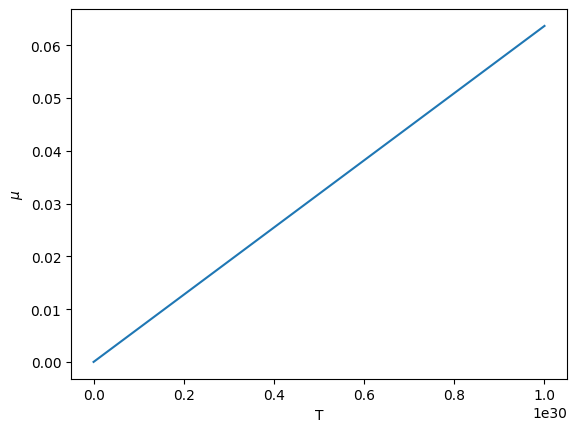

In [20]:
plt.plot(n, mu)

plt.xlabel('T')
plt.ylabel('$\mu$')
plt.show()


In [21]:
# case 2 solve for diffrent E profiels with relatavistic depainace, then solve intergral for the



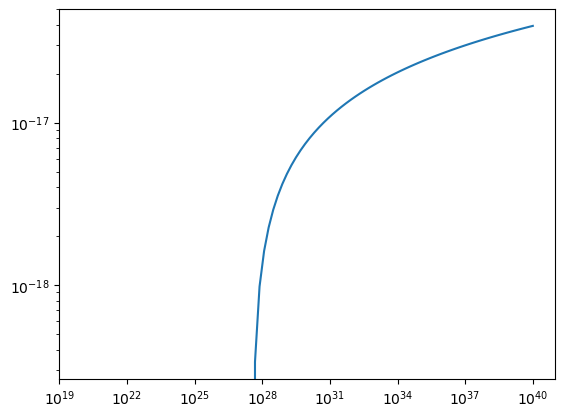

In [8]:
# Eric - Try basic case of ideal monatomic gas (mu/kT << -1) ie purely classical, with elementart partivles and no relativistic effects

def most_simple_mu(T, n, E0, g, m):
    """
    Calculate the chemical potential (mu) using the most simple case.
    
    Args:
        T (float): Temperature in Kelvin.
        n (float): Number density.
        E0 (float): Energy.
        g (float): Degeneracy.
        m (float): Particle mass.
    
    Returns:
        float: The chemical potential (mu).
    """
    # Calculate the chemical potential using the given formula
    mu = c.k_B * T * np.log((n * c.h**3) / (g * (2 * np.pi * m * c.k_B * T)**(3/2)) * np.exp(E0 / c.k_B / T))
    
    return mu

# T = np.logspace(-10, 20, 100) * u.K
# n = 5*10**40 * u.cm**-3

T = 100000 * u.K
n = np.logspace(20, 40, 100) * u.cm**-3

E0 = 10* u.eV
g = 2
m = 1 * u.u

plt.plot(n, most_simple_mu(T, n, E0, g, m))
plt.xscale('log')
plt.yscale('log')

In [2]:
# Chat-GPTs suggestion for solving mu as a function of n, Equation 3.44 and 3.45 in Kawaler and Hansen

import sympy as sp

In [ ]:
n, mu = sp.symbols('n mu')
p = sp.symbols('p')

T = 100000 * u.K
m = 1 * u.u


equation = sp.Eq(n, 8*np.pi/c.h**3 * sp.integrate(p**2/(1 + np.exp((-1*mu + m*c.c**2 + m*c.c**2*(np.sqrt(1+(p/m/c.c)**2)-1))/c.k_B*T)), (p, 0, np.inf)))

: 

: 